In [41]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps, cumtrapz, romb 
%matplotlib inline
import math

In [42]:
todays_date = ql.Date(15, 1, 2015)
ql.Settings.instance().evaluationDate = todays_date

In [43]:
def get_path_generator(timestep, hw_process, length, low_discrepancy=False, brownian_bridge=True):
    
    if low_discrepancy:
        usg = ql.UniformLowDiscrepancySequenceGenerator(timestep)
        rng = ql.GaussianLowDiscrepancySequenceGenerator(usg)
        seq = ql.GaussianSobolPathGenerator(hw_process, length, timestep, rng,brownian_bridge)
    else:
        usg = ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator())
        rng = ql.GaussianRandomSequenceGenerator(usg)
        seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, brownian_bridge)
    return seq

In [44]:
def generate_paths(num_paths, timestep, seq): 
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))] 
        value = [path[j] for j in range(len(path))] 
        arr[i, :] = np.array(value)
    return np.array(time), arr

In [45]:
def generate_paths_zero_price(spot_curve_handle, a, sigma, timestep, length, num_paths, avg_grid_array, low_discrepancy=False, brownian_bridge=True):
    """
    This function returns a tuple (T_array, F_array), where T_array is the array
    of points in the time grid, and F_array is the array of the average of zero
    prices observed from the simulation.
    """
    hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
    seq = get_path_generator(timestep, hw_process, length, low_discrepancy, brownian_bridge)
    time, paths = generate_paths(num_paths, timestep, seq)
    avgs = [(time[j],(np.mean([math.exp(-simps(paths[i][0:j], time[0:j]))
                               for i in range(num_paths)]))) 
            for j in avg_grid_array]
    return zip(*avgs)

In [51]:
def generate_paths_discount_factors(spot_curve_handle, a, sigma, timestep, length, num_paths, avg_grid_array, low_discrepancy=False, brownian_bridge=True):
    """
    This function returns a tuple (T_array, S_matrix), where T_array is the array
    of points in the time grid, and S_matrix is the matrix of the spot rates for
    each path in the different points in the time grid.
    """
    hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
    seq = get_path_generator(timestep, hw_process, length, low_discrepancy, brownian_bridge)
    time, paths = generate_paths(num_paths, timestep, seq) 
    arr = np.zeros((num_paths, len(avg_grid_array)))
    for i in range(num_paths):
        arr[i, :] = [np.exp(-simps(paths[i][0:j], time[0:j])) for j in avg_grid_array]
        t_array = [time[j] for j in avg_grid_array]
        return t_array, arr

In [52]:
def V(t,T, a, sigma):
    """ Variance of the integral of short rates, used below""" 
    return sigma*sigma/a/a*(T-t + 2.0/a*math.exp(-a*(T-t)) - 1.0/(2.0*a)*math.exp(-2.0*a*(T-t)) - 3.0/(2.0*a) )

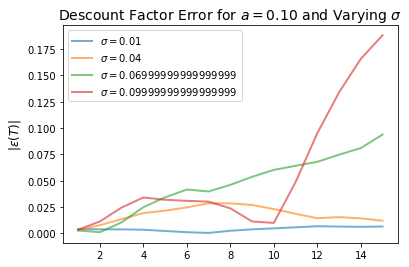

In [53]:
# Here we vary sigma with fixed a and observe the error epsilon
# define constants
num_paths = 100
sigma_array = np.arange(0.01,0.1,0.03)
a = 0.1
timestep = 180
length = 15 # in years
forward_rate = 0.05
day_count = ql.Thirty360(ql.Thirty360.BondBasis)
avg_grid_array = np.arange(12, timestep+1, 12)
# generate spot curve
spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)
#initialize plots
figure, axis = plt.subplots()
plots = []
zero_price_theory = np.array([spot_curve.discount(j*float(length)/float(timestep)) for j in avg_grid_array])
for sigma in sigma_array:
    term, zero_price_empirical = generate_paths_zero_price(spot_curve_handle, a, sigma, timestep, length, num_paths, avg_grid_array)
    plots += axis.plot(term, np.abs(zero_price_theory - np.array(zero_price_empirical)), lw=2, alpha=0.6, label="$\sigma=$"+str(sigma))
    
    


# plot legend
labels = [p.get_label() for p in plots]
legend =axis.legend(plots,labels, loc=0)#, loc=0, bbox_to_anchor=(1.1,0.4)) axis.set_xlabel("T (years)", size=12)
axis.set_ylabel("|$\epsilon(T)$|", size=12)
axis.set_title("Descount Factor Error for $a=$%0.2f and Varying $\sigma$"%a, size=14)
plt.show()

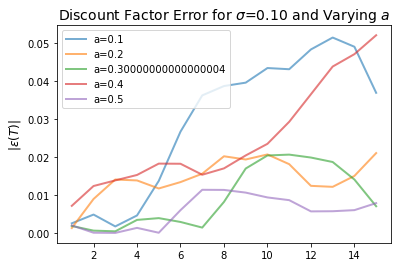

In [54]:
# Here we vary a with fixed sigma and observe the error epsilon
#define constants
num_paths = 500
sigma = 0.1
a_array = np.arange(0.1, 0.51, 0.1)
timestep = 180
length = 15 # in years
forward_rate = 0.05
day_count = ql.Thirty360(ql.Thirty360.BondBasis)
avg_grid_array = np.arange(12, timestep+1, 12)
# generate spot curve
spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)
#initialize plots
figure, axis = plt.subplots()
plots = []
zero_price_theory = np.array([spot_curve.discount(j*float(length)/float(timestep))
                              for j in avg_grid_array])
for a in a_array:
    term, zero_price_empirical = generate_paths_zero_price(spot_curve_handle, a, sigma, timestep, length, num_paths, avg_grid_array)
    plots += axis.plot(term,np.abs(zero_price_theory - np.array(zero_price_empirical)), lw=2, alpha=0.6, label="a="+str(a))

# plot legend
labels = [p.get_label() for p in plots]
legend =axis.legend(plots,labels, loc=0)#, loc=0, bbox_to_anchor=(1.1,0.4)) axis.set_xlabel("T (years)", size=12)
axis.set_ylabel("|$\epsilon(T)$|", size=12)
axis.set_title("Discount Factor Error for $\sigma$=%0.2f and Varying $a$"%sigma, size=14)
plt.show()

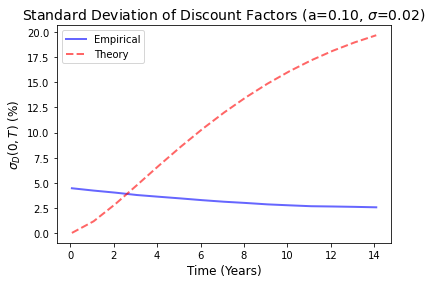

In [55]:
#define constants
num_paths = 500
sigma = 0.02
a = 0.1
timestep = 180
length = 15 # in years
forward_rate = 0.05
day_count = ql.Thirty360(ql.Thirty360.BondBasis)
avg_grid_array = np.arange(1, timestep+1, 12)

# generate spot curve
spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve) 

term, discount_factor_matrix = generate_paths_discount_factors(spot_curve_handle, a, sigma, timestep, length, num_paths, avg_grid_array)

vol = [np.var(discount_factor_matrix[:, i]) for i in range(len(term))]

l1 = plt.plot(term, 100*np.sqrt(vol),"b", lw=2, alpha=0.6,label="Empirical") 

vol_theory = [100*np.sqrt(math.exp(V(0,T,a, sigma))-1.0) * spot_curve_handle.discount(T) for T in term]

l2 = plt.plot(term, vol_theory,"r--", lw=2, alpha=0.6,label="Theory")

plots = l1+l2
labels = [p.get_label() for p in plots]
legend =plt.legend(plots,labels, loc=0) 
plt.xlabel("Time (Years)", size=12) 
plt.ylabel("$\sigma_D(0,T)$ (%)", size=12) 
plt.title("Standard Deviation of Discount Factors "
"(a=%0.2f, $\sigma$=%0.2f)"%(a, sigma), size=14) 
plt.show()